In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
# install tf 2.0
from __future__ import absolute_import, division, print_function, unicode_literals

!pip install tensorflow-gpu==2.0.0-alpha0
import tensorflow as tf
# tf.compat.v1.disable_eager_execution()

print(tf.__version__)

    100% |████████████████████████████████| 332.1MB 34kB/s 
    100% |████████████████████████████████| 61kB 29.4MB/s 
    100% |████████████████████████████████| 419kB 13.4MB/s 
    100% |████████████████████████████████| 3.0MB 10.2MB/s 
2.0.0-alpha0


In [0]:
import os
from glob import glob

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

SEED = 42


def _float_list_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))


def _int64_list_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))


def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def create_generator_for_ffn(
        file_list,
        mode='train'):

    # file_list = glob(os.path.join(data_dir, '*.csv'))

    for full_file_path in file_list:
        # full_file_path = os.path.join(data_dir, file_name)
        if not os.path.exists(full_file_path):
            raise FileNotFoundError("File %s not found" % full_file_path)
        df = pd.read_csv(full_file_path, encoding='utf8')

        # so train test split
        if mode == 'train':
            df, _ = train_test_split(df, test_size=0.2, random_state=SEED)
        else:
            _, df = train_test_split(df, test_size=0.2, random_state=SEED)

        for _, row in df.iterrows():
            q_vectors = np.fromstring(row.question_bert.replace(
                '[[', '').replace(']]', ''), sep=' ')
            a_vectors = np.fromstring(row.answer_bert.replace(
                '[[', '').replace(']]', ''), sep=' ')
            vectors = np.stack([q_vectors, a_vectors], axis=0)
            if mode in ['train', 'eval']:
                yield vectors, 1
            else:
                yield vectors


def ffn_serialize_fn(features):
    features_tuple = {'features': _float_list_feature(
        features[0].flatten()), 'labels': _int64_feature(features[1])}
    example_proto = tf.train.Example(
        features=tf.train.Features(feature=features_tuple))
    return example_proto.SerializeToString()


def make_tfrecord(data_dir, generator_fn, serialize_fn, suffix='', **kwargs):
    """Function to make TF Records from csv files
    This function will take all csv files in data_dir, convert them
    to tf example and write to *_{suffix}_train/eval.tfrecord to data_dir.

    Arguments:
        data_dir {str} -- dir that has csv files and store tf record
        generator_fn {fn} -- A function that takes a list of filepath and yield the
        parsed recored from file.
        serialize_fn {fn} -- A function that takes output of generator fn and convert to tf example

    Keyword Arguments:
        suffix {str} -- suffix to add to tf record files (default: {''})
    """
    file_list = glob(os.path.join(data_dir, '*.csv'))
    train_tf_record_file_list = [
        f.replace('.csv', '_{0}_train.tfrecord'.format(suffix)) for f in file_list]
    test_tf_record_file_list = [
        f.replace('.csv', '_{0}_eval.tfrecord'.format(suffix)) for f in file_list]
    for full_file_path, train_tf_record_file_path, test_tf_record_file_path in zip(file_list, train_tf_record_file_list, test_tf_record_file_list):
        print('Converting file {0} to TF Record'.format(full_file_path))
        with tf.io.TFRecordWriter(train_tf_record_file_path) as writer:
            for features in generator_fn([full_file_path], mode='train', **kwargs):
                example = serialize_fn(features)
                writer.write(example)
        with tf.io.TFRecordWriter(test_tf_record_file_path) as writer:
            for features in generator_fn([full_file_path], mode='eval', **kwargs):
                example = serialize_fn(features)
                writer.write(example)


def create_dataset_for_ffn(
        data_dir,
        mode='train',
        hidden_size=768,
        shuffle_buffer=10000,
        prefetch=10000,
        batch_size=32):

    tfrecord_file_list = glob(os.path.join(
        data_dir, '*_FFN_{0}.tfrecord'.format((mode))))
    if not tfrecord_file_list:
        print('TF Record not found')
        make_tfrecord(
            data_dir, create_generator_for_ffn,
            ffn_serialize_fn, 'FFN')

    dataset = tf.data.TFRecordDataset(tfrecord_file_list)

    def _parse_ffn_example(example_proto):
        feature_description = {
            'features': tf.io.FixedLenFeature([2*768], tf.float32),
            'labels': tf.io.FixedLenFeature([], tf.int64, default_value=0),
        }
        feature_dict = tf.io.parse_single_example(
            example_proto, feature_description)
        return tf.reshape(feature_dict['features'], (2, 768)), feature_dict['labels']
    dataset = dataset.map(_parse_ffn_example)

    dataset = dataset.shuffle(shuffle_buffer)

    dataset = dataset.prefetch(prefetch)

    dataset = dataset.batch(batch_size)
    return dataset

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

import tensorflow as tf
import tensorflow.keras.backend as K


class FFN(tf.keras.layers.Layer):
    def __init__(
            self,
            hidden_size=768,                                                                #SG edit from 768 4-24-19
            dropout=0.2,
            residual=True,
            name='FFN',
            **kwargs):
        """Simple Dense wrapped with various layers
        """

        super(FFN, self).__init__(name=name, **kwargs)
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.residual = residual
        self.ffn_layer = tf.keras.layers.Dense(
            units=hidden_size,
            use_bias=True
        )

    def call(self, inputs):
        ffn_embedding = self.ffn_layer(inputs)
        ffn_embedding = tf.keras.layers.ReLU()(ffn_embedding)
        if self.dropout > 0:
            ffn_embedding = tf.keras.layers.Dropout(
                self.dropout)(ffn_embedding)
#         ffn_embedding = self.ffn_layer(inputs)  #SG edit from 768 4-24-19
#         ffn_embedding = tf.keras.layers.ReLU()(ffn_embedding)  #SG edit from 768 4-24-19
#         if self.dropout > 0:  #SG edit from 768 4-24-19
#             ffn_embedding = tf.keras.layers.Dropout(  #SG edit from 768 4-24-19
#                 self.dropout)(ffn_embedding)  #SG edit from 768 4-24-19


        if self.residual:
            ffn_embedding += inputs
        return ffn_embedding


class MedicalQAModel(tf.keras.Model):
    def __init__(self, name=''):
        super(MedicalQAModel, self).__init__(name=name)
        self.q_ffn = FFN(name='QFFN', input_shape=(768,))
        self.a_ffn = FFN(name='AFFN', input_shape=(768,))

    def call(self, inputs):
        q_bert_embedding, a_bert_embedding = tf.unstack(inputs, axis=1)
        q_embedding, a_embedding = self.q_ffn(
            q_bert_embedding), self.a_ffn(a_bert_embedding)
        return tf.stack([q_embedding, a_embedding], axis=1)


class BioBert(tf.keras.Model):
    def __init__(self, name=''):
        super(BioBert, self).__init__(name=name)

    def call(self, inputs):

        # inputs is dict with input features
        input_ids, input_masks, segment_ids = inputs
        # pass to bert
        # with shape of (batch_size/2*batch_size, max_seq_len, hidden_size)
        # TODO(Alex): Add true bert model
        # Input: input_ids, input_masks, segment_ids all with shape (None, max_seq_len)
        # Output: a tensor with shape (None, max_seq_len, hidden_size)
        fake_bert_output = tf.expand_dims(tf.ones_like(
            input_ids, dtype=tf.float32), axis=-1)*tf.ones([1, 1, 768], dtype=tf.float32)
        max_seq_length = tf.shape(fake_bert_output)[-2]
        hidden_size = tf.shape(fake_bert_output)[-1]

        bert_output = tf.reshape(
            fake_bert_output, (-1, 2, max_seq_length, hidden_size))
        return bert_output


class MedicalQAModelwithBert(tf.keras.Model):
    def __init__(
            self,
            hidden_size=768,
            dropout=0.2,
            residual=True,
            activation=tf.keras.layers.ReLU(),
            name=''):
        super(MedicalQAModelwithBert, self).__init__(name=name)
        self.biobert = BioBert()
        self.q_ffn_layer = FFN(
            hidden_size=hidden_size,
            dropout=dropout,
            residual=residual,
            activation=activation)
        self.a_ffn_layer = FFN(
            hidden_size=hidden_size,
            dropout=dropout,
            residual=residual,
            activation=activation)

    def _avg_across_token(self, tensor):
        if tensor is not None:
            tensor = tf.reduce_mean(tensor, axis=1)
        return tensor

    def call(self, inputs):

        q_bert_embedding, a_bert_embedding = self.biobert(inputs)

        # according to USE, the DAN network average embedding across tokens
        q_bert_embedding = self._avg_across_token(q_bert_embedding)
        a_bert_embedding = self._avg_across_token(a_bert_embedding)

        q_embedding = self.q_ffn_layer(q_bert_embedding)
        a_embedding = self.a_ffn_layer(a_bert_embedding)

        return tf.stack([q_embedding, a_embedding], axis=1)

      
      
# def qa_pair_cross_entropy_loss(y_true, y_pred):
#     y_true = tf.eye(tf.shape(y_pred)[0])
#     q_embedding, a_embedding = tf.unstack(y_pred, axis=1)
#     similarity_matrix = tf.matmul(
#         q_embedding, a_embedding, transpose_b=True)
#     similarity_matrix_logits = tf.math.sigmoid(similarity_matrix)
#     return tf.keras.losses.categorical_crossentropy(y_true, similarity_matrix_logits, from_logits=True)

def qa_pair_cross_entropy_loss(y_true, y_pred):
    y_true = tf.eye(tf.shape(y_pred)[0])
    q_embedding, a_embedding = tf.unstack(y_pred, axis=1)
    similarity_matrix = tf.matmul(
        a = q_embedding, b = a_embedding, transpose_b=True)
    similarity_matrix_softmaxed = tf.nn.softmax(similarity_matrix)
    K.print_tensor(similarity_matrix_softmaxed, message="similarity_matrix_softmaxed is: ")
    return tf.keras.losses.categorical_crossentropy(y_true, similarity_matrix_softmaxed, from_logits=False)

#     y_true = tf.reshape(tf.eye(tf.shape(y_pred)[0])*2-1, (-1,))
#     q_embedding, a_embedding = tf.unstack(y_pred, axis=1)
#     similarity_matrix = tf.nn.softmax(tf.matmul(
#         q_embedding, a_embedding, transpose_b=True))
#     similarity_vector = tf.reshape(similarity_matrix, (-1, 1))
#     return tf.nn.softmax_cross_entropy_with_logits(similarity_vector, y_true)

#to try, with and without softmax
# catagorical cross entropy vs binary cross entropy
#with and without sigmoid pre transformation
#1 layer vs 2 layer 

#prioritize what he said. so softmax, then catagorical vs binary 


In [0]:
# training config
batch_size = 128
num_epochs=35
learning_rate=0.0001
validation_split=0.2
shuffle_buffer=50000
prefetch=50000
data_path='/content/gdrive/My Drive/mqa_tf_record'
model_path = '/content/gdrive/My Drive/mqa_models/ffn_model_cross_entropy'

In [0]:
  d = create_dataset_for_ffn(
      data_path, batch_size=batch_size, shuffle_buffer=shuffle_buffer, prefetch=prefetch)
  eval_d = create_dataset_for_ffn(
      data_path, batch_size=batch_size, mode='eval')
  medical_qa_model = MedicalQAModel()
  optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
  medical_qa_model.compile(
      optimizer=optimizer, loss=qa_pair_cross_entropy_loss)

  epochs = num_epochs
  loss_metric = tf.keras.metrics.Mean()

#   history = medical_qa_model.fit(d, epochs=epochs, validation_data=eval_d)


In [0]:

model_path2 = '/content/gdrive/My Drive/mqa_models/ffn_model_cross_entropy.ckpt'

checkpoint = tf.keras.callbacks.ModelCheckpoint(model_path2, monitor='loss', verbose=1, save_best_only=True)

In [8]:
checkpoint_dir = os.path.dirname(model_path2)
print(checkpoint_dir)

/content/gdrive/My Drive/mqa_models


In [9]:
medical_qa_model.load_weights(model_path2)

In [10]:
history = medical_qa_model.fit(d, epochs=80, validation_data=eval_d,  callbacks=[checkpoint])

Epoch 1/80


W0426 20:45:43.031697 140162562127744 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/backend.py:2924: Print (from tensorflow.python.ops.logging_ops) is deprecated and will be removed after 2018-08-20.
Instructions for updating:
Use tf.print instead of tf.Print. Note that tf.print returns a no-output operator that directly prints the output. Outside of defuns or eager mode, this operator will not be executed unless it is directly specified in session.run or used as a control dependency for other operators. This is only a concern in graph mode. Below is an example of how to ensure tf.print executes in graph mode:
```python
    sess = tf.Session()
    with sess.as_default():
        tensor = tf.range(10)
        print_op = tf.print(tensor)
        with tf.control_dependencies([print_op]):
          out = tf.add(tensor, tensor)
        sess.run(out)
    ```
Additionally, to use tf.print in python 2.7, users must make sure to import
the following:

 

    179/Unknown - 11s 64ms/step - loss: 1.8521

KeyboardInterrupt: ignored

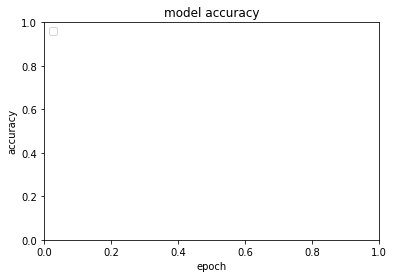

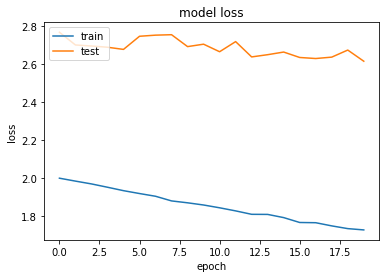

In [0]:
import matplotlib.pyplot as plt
# summarize history for accuracy
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [14]:
input_data = next(iter(d))
print('input data is ', input_data)

input data is  (<tf.Tensor: id=67682, shape=(128, 2, 768), dtype=float32, numpy=
array([[[-0.04685886, -0.10289637, -0.4312089 , ...,  0.6716723 ,
          0.03079298,  0.00706173],
        [ 0.17568265,  0.17470282, -0.07537014, ...,  0.3922773 ,
          0.218182  , -0.27046928]],

       [[-0.05585075,  0.24309337, -0.15819737, ...,  0.3807708 ,
          0.11023071,  0.05866839],
        [ 0.15998061,  0.41866085,  0.1743543 , ...,  0.41534692,
          0.38362348, -0.04816403]],

       [[-0.12419132,  0.13910837, -0.11075334, ...,  0.38130343,
         -0.07294474, -0.24760696],
        [ 0.05594226,  0.17657183, -0.32214007, ...,  0.2297752 ,
         -0.02246851,  0.10338924]],

       ...,

       [[-0.08374447,  0.4017603 , -0.18001199, ...,  0.22693412,
          0.23821752,  0.02205274],
        [-0.17068203,  0.1651842 , -0.3762887 , ...,  0.3074351 ,
          0.186731  , -0.11767841]],

       [[ 0.18684188,  0.34592396, -0.03621193, ...,  0.25407133,
          0.2277

In [11]:
K.set_learning_phase(0)

input_data = next(iter(d))[0]
print('input data is ', input_data)


q_embedding, a_embedding = tf.unstack(medical_qa_model(input_data), axis=1)

q_embedding = q_embedding / tf.norm(q_embedding, axis=-1, keepdims=True)
a_embedding = a_embedding / tf.norm(a_embedding, axis=-1, keepdims=True)

print('q_embedding', q_embedding)
print('a_embedding', a_embedding)

batch_score = tf.reduce_sum(q_embedding*a_embedding, axis=-1)
baseline_score = tf.reduce_mean(tf.matmul(q_embedding,tf.transpose(a_embedding)))

print('Training Batch Cos similarity')
print(tf.reduce_mean(batch_score))
print('Baseline: {0}'.format(baseline_score))

input data is  tf.Tensor(
[[[-0.01894781  0.1705342  -0.23431076 ...  0.2526984   0.03581299
   -0.04693769]
  [-0.00811298  0.0787234   0.12227986 ...  0.11041731  0.0836745
   -0.01399889]]

 [[ 0.25619757  0.20239824 -0.17506284 ...  0.29687408  0.02388489
   -0.4853307 ]
  [ 0.06884078  0.02883266  0.02382688 ...  0.17812629  0.17053054
   -0.235822  ]]

 [[-0.13511476  0.30704442 -0.01675423 ...  0.48951083  0.04952382
   -0.08286653]
  [-0.15257362  0.20668145  0.08815259 ...  0.4345324   0.09320357
    0.04498511]]

 ...

 [[ 0.27033815 -0.08848304 -0.34093153 ...  0.23688368  0.232592
   -0.1686028 ]
  [-0.00228444  0.20956993 -0.39943475 ...  0.49659503  0.26085627
   -0.19215202]]

 [[ 0.00955392  0.28275514  0.04052498 ...  0.14644516  0.18197495
   -0.16054386]
  [-0.04791677  0.18572612  0.00437022 ...  0.13283327  0.06079603
    0.17652841]]

 [[-0.22888634  0.09931215 -0.06191296 ...  0.36640286  0.03239492
   -0.31243005]
  [-0.1376928   0.29751766 -0.5105773  ...  0.02

In [0]:
eval_d = create_dataset_for_ffn(data_dir='/content/gdrive/My Drive/mqa-biobert', mode='eval', batch_size=64)
q_embedding, a_embedding = medical_qa_model(next(iter(eval_d)))

q_embedding = q_embedding / tf.norm(q_embedding, axis=-1, keepdims=True)
a_embedding = a_embedding / tf.norm(a_embedding, axis=-1, keepdims=True)

batch_score = tf.reduce_sum(q_embedding*a_embedding, axis=-1)
baseline_score = tf.reduce_mean(tf.matmul(q_embedding,tf.transpose(a_embedding)))

print('Eval Batch Cos similarity')
print(tf.reduce_mean(batch_score))
print('Baseline: {0}'.format(baseline_score))

In [0]:
d = create_dataset_for_ffn(
  data_path, batch_size=batch_size, shuffle_buffer=shuffle_buffer, prefetch=prefetch)
eval_d = create_dataset_for_ffn(
  data_path, batch_size=batch_size, mode='eval')

# save arrays
from itertools import chain

q_embedding_list = []
a_embedding_list = []

for feature_dict in chain(iter(d), iter(eval_d)):
  q_embedding, a_embedding = tf.unstack(medical_qa_model(feature_dict[0]), axis=1)

  q_embedding_list.append(q_embedding / tf.norm(q_embedding, axis=-1, keepdims=True))
  a_embedding_list.append(a_embedding / tf.norm(a_embedding, axis=-1, keepdims=True))

In [0]:
result_path = '/content/gdrive/My Drive/mqa_ffn_results/'
os.makedirs(result_path, exist_ok=True)
np.save(os.path.join(result_path, 'q_embedding.npz'), np.concatenate(q_embedding_list, axis=0))
  

np.save(os.path.join(result_path, 'a_embedding.npz'), np.concatenate(a_embedding_list, axis=0) )
  

In [0]:
# medical_qa_model.save_weights(model_path)